# PC-GMM Composites

In [1]:
from importlib import reload
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy as ctp

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")


In [2]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../output/pcgmm/pcgmm_1stpaperdraft/pcgmm_weights_month_sst.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']


In [3]:
# Load data
# =======================================================================================
reload(preproc)
vars = ['sst', 'ssh', 'olr']
climatology = 'month'
f_sst = "../data/reanalysis/monthly/ERA5/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc"

datapath = {
    'sst':    f"../data/reanalysis/monthly/ORAS5/sea_surface_temperature_oras5_single_level_1958_2023_1x1.nc",
    'ssh':    f"../data/reanalysis/monthly/ORAS5/sea_surface_height_oras5_single_level_1958_2023_1x1.nc",
    't2m':    f"../data/reanalysis/monthly/ERA5/2m_temperature_era5_monthly_sp_1940-2022_2.5x2.5.nc",
    'olr':    f"../data/reanalysis/monthly/ERA5/olr_era5_monthly_sp_1940-2022_2.5x2.5.nc",
}

da4comp = {}
for var in vars:
    print(f"Load {var}")
    temp = preproc.process_data(
        datapath[var], vars=[var], antimeridian=False,
        lon_range=[-180, 179], lat_range=[-80, 80],
        grid_step=2.5, climatology=climatology, normalization=None
    )
    temp = temp[f"{var}a"]
    temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
    da4comp[f"{var}a"] = temp

Load sst
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:
Load ssh
Sort longitudes and latitudes in ascending order, respectively
Process ssh:


/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convertin

Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:
Load olr
Sort longitudes and latitudes in ascending order, respectively
Process olr:


/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convertin

Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:


/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_12255/317191182.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convertin

## Probabilistic weighted composites

In [4]:
# Parameters
n_samples_mean = 1000
alpha = 0.05
null_hypothesis = 'neutral'
stattest = 'pos'
multiple_testing= 'dunn'

In [5]:
# Weighted composites
reload(utenso)
composites_prob, mask_prob, samples_null_prob, pvals_prob = utenso.get_weighted_composites(
    da4comp, f_sst, weight_month_mean, null_hypothesis=null_hypothesis,
    stattest=stattest, n_samples_mean=n_samples_mean, alpha=alpha,
    multiple_testing=multiple_testing, serial_data=False
)


Sort longitudes and latitudes in ascending order, respectively
Weighted composite for ssta
Times samples of null-distribution: 39
Num of samples for null hypothesis: 64


/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  weights_var['time'] = np.array(weights_var['time'].data, dtype='datetime64[M]')
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Var

Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1508.34it/s]


Num of samples for null hypothesis: 50
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1556.09it/s]


Num of samples for null hypothesis: 10
Percentile of score for c=3


100%|██████████| 9360/9360 [00:06<00:00, 1547.94it/s]


Num of samples for null hypothesis: 48
Percentile of score for c=4


100%|██████████| 9360/9360 [00:06<00:00, 1506.82it/s]


Num of samples for null hypothesis: 65
Percentile of score for c=5


100%|██████████| 9360/9360 [00:06<00:00, 1448.19it/s]
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  weights_var['time'] = np.array(weights_var['time'].data, dtype='datetime64[M]')
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datet

Weighted composite for ssha
Times samples of null-distribution: 39
Num of samples for null hypothesis: 64
Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1456.63it/s]


Num of samples for null hypothesis: 50
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1457.06it/s]


Num of samples for null hypothesis: 10
Percentile of score for c=3


100%|██████████| 9360/9360 [00:07<00:00, 1315.92it/s]


Num of samples for null hypothesis: 48
Percentile of score for c=4


100%|██████████| 9360/9360 [00:07<00:00, 1302.11it/s]


Num of samples for null hypothesis: 65
Percentile of score for c=5


100%|██████████| 9360/9360 [00:07<00:00, 1276.64it/s]
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  weights_var['time'] = np.array(weights_var['time'].data, dtype='datetime64[M]')
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1183: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datet

Weighted composite for olra
Times samples of null-distribution: 63
Num of samples for null hypothesis: 91
Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1366.76it/s]


Num of samples for null hypothesis: 58
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1411.57it/s]


Num of samples for null hypothesis: 10
Percentile of score for c=3


100%|██████████| 9360/9360 [00:06<00:00, 1474.55it/s]


Num of samples for null hypothesis: 70
Percentile of score for c=4


100%|██████████| 9360/9360 [00:06<00:00, 1470.56it/s]


Num of samples for null hypothesis: 88
Percentile of score for c=5


100%|██████████| 9360/9360 [00:06<00:00, 1377.15it/s]


/tmp/ipykernel_12255/3382556715.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/pcgmm/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_12255/3382556715.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/pcgmm/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


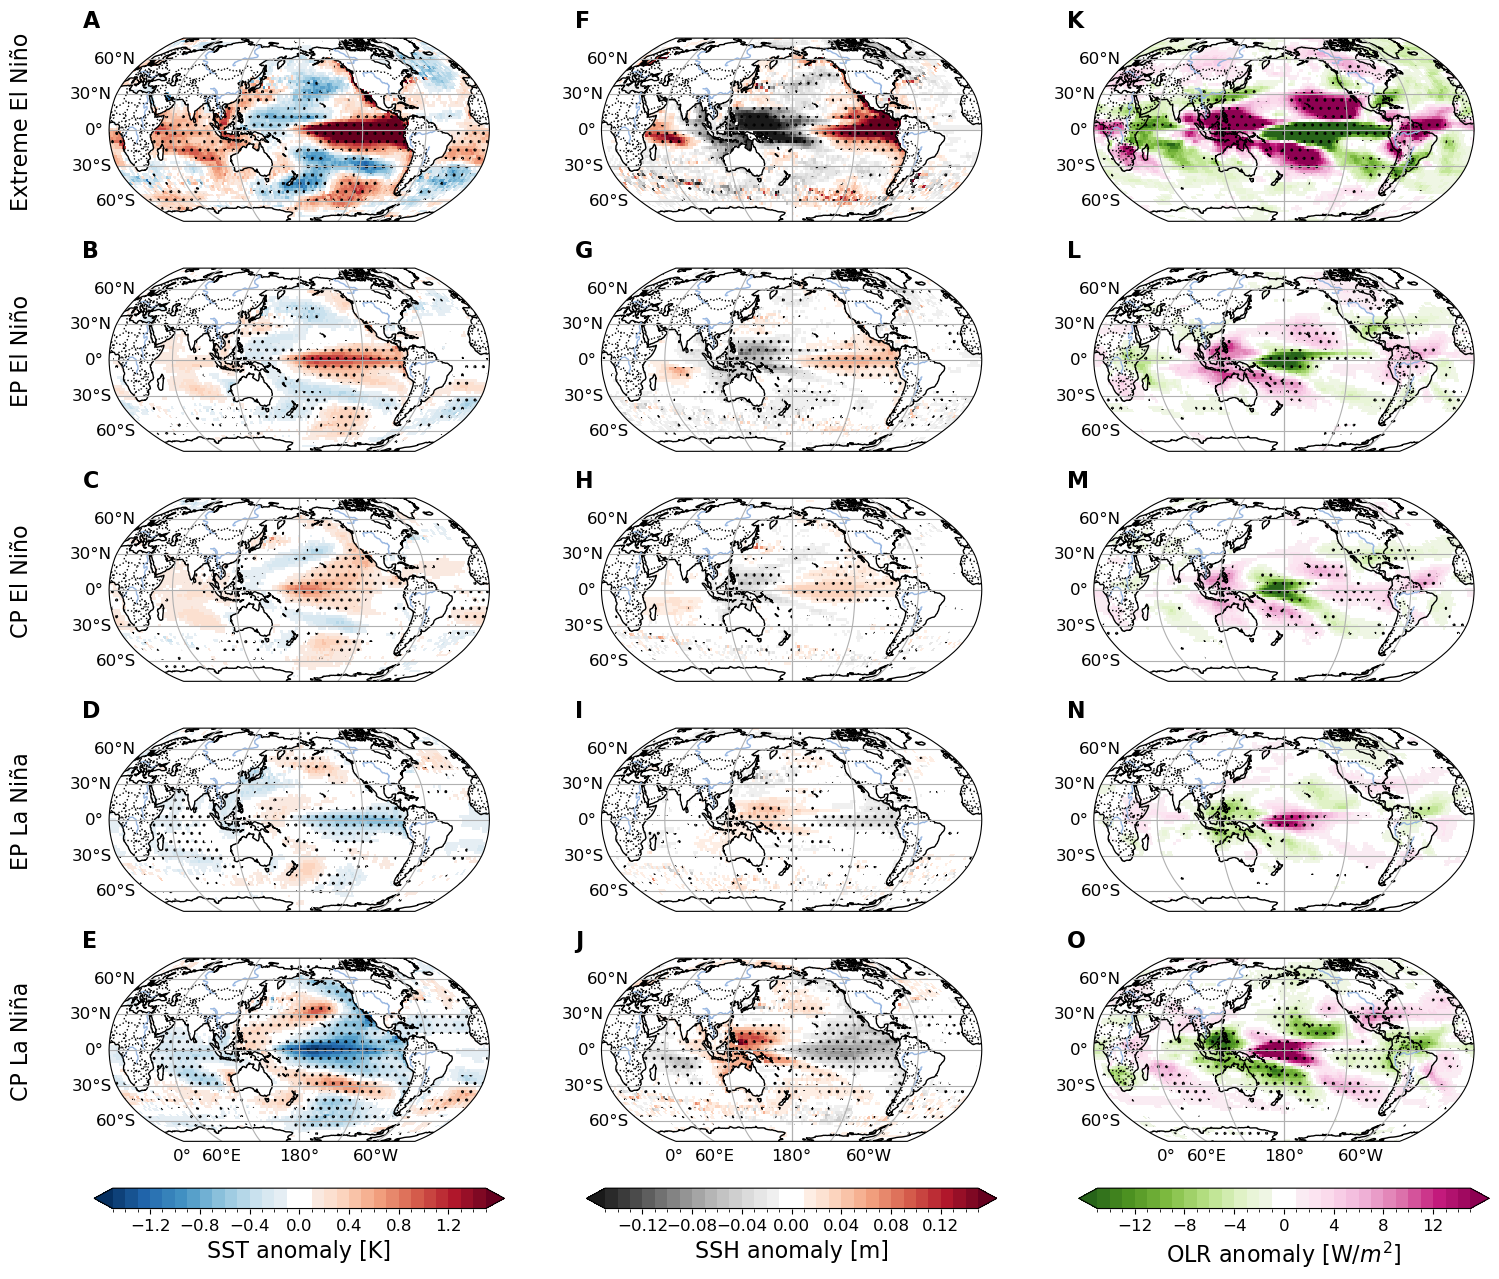

In [6]:
# Plot weighted composites
# ===============================================
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.1, label='SST anomaly [K]'),
    'ssha': dict(cmap='RdGy_r', vmin=-.15, vmax=.15, step=.01, label='SSH anomaly [m]'),
    't2ma': dict(cmap='RdBu_r', vmin=None, vmax=None, step=.25, label='2m temperature anomaly'),
    'olra': dict(cmap='PiYG_r', vmin=-15, vmax=15, step=1, label=r'OLR anomaly [W/$m^2$]'),
}
labels = ["Extreme El Niño" ,"EP El Niño", "CP El Niño", "EP La Niña", "CP La Niña"]
n_columns = len(composites_prob.data_vars)
n_rows = len(composites_prob['classes'])
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

axs = []
for j in range(n_columns):
    for i in range(n_rows):
        idx = gmm_order[i] + 1
        var = list(composites_prob.data_vars)[j]
        comp = composites_prob[var].sel(classes=idx)
        mask = mask_prob[var].sel(classes=idx)
        ax = fig.add_subplot(gs[i, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax, hatch="..",
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False
        axs.append(ax)

        if j == 0:
            ax.text(-0.2, 0.55, rf"{labels[i]}", va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=16) 

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-
                           0.07, pos_y=1.06, fontsize=16)

plt.savefig("../output/plots/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')

## Unweighted composites

In [7]:
# Unweighted composites
reload(utenso)
composites_unweight, mask_unweight, composites_null, samples_null_unweight, pvalues_unweight = utenso.get_unweighted_composites(
    da4comp, f_sst, stattest=stattest, null_hypothesis=null_hypothesis,
    n_samples_mean=n_samples_mean, alpha=alpha,
    serial_data=False, multiple_testing=multiple_testing
)


Sort longitudes and latitudes in ascending order, respectively
Time points of null-hypothesis: 54
Num of datapoints Nino_EP: 21
Percentile of score for Nino_EP


100%|██████████| 9360/9360 [00:07<00:00, 1329.04it/s]


Num of datapoints Nino_CP: 21
Percentile of score for Nino_CP


100%|██████████| 9360/9360 [00:07<00:00, 1324.47it/s]


Num of datapoints Nina_EP: 36
Percentile of score for Nina_EP


100%|██████████| 9360/9360 [00:07<00:00, 1317.88it/s]


Num of datapoints Nina_CP: 27
Percentile of score for Nina_CP


100%|██████████| 9360/9360 [00:07<00:00, 1328.72it/s]


Time points of null-hypothesis: 54
Num of datapoints Nino_EP: 21
Percentile of score for Nino_EP


100%|██████████| 9360/9360 [00:07<00:00, 1321.06it/s]


Num of datapoints Nino_CP: 21
Percentile of score for Nino_CP


100%|██████████| 9360/9360 [00:06<00:00, 1365.89it/s]


Num of datapoints Nina_EP: 36
Percentile of score for Nina_EP


100%|██████████| 9360/9360 [00:06<00:00, 1385.49it/s]


Num of datapoints Nina_CP: 27
Percentile of score for Nina_CP


100%|██████████| 9360/9360 [00:06<00:00, 1344.59it/s]


Time points of null-hypothesis: 78
Num of datapoints Nino_EP: 36
Percentile of score for Nino_EP


100%|██████████| 9360/9360 [00:07<00:00, 1329.39it/s]


Num of datapoints Nino_CP: 24
Percentile of score for Nino_CP


100%|██████████| 9360/9360 [00:07<00:00, 1277.75it/s]


Num of datapoints Nina_EP: 45
Percentile of score for Nina_EP


100%|██████████| 9360/9360 [00:07<00:00, 1257.01it/s]


Num of datapoints Nina_CP: 30
Percentile of score for Nina_CP


100%|██████████| 9360/9360 [00:07<00:00, 1274.42it/s]


/tmp/ipykernel_12255/2152491817.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/pcgmm_unweighted_composites.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_12255/2152491817.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/pcgmm_unweighted_composites.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


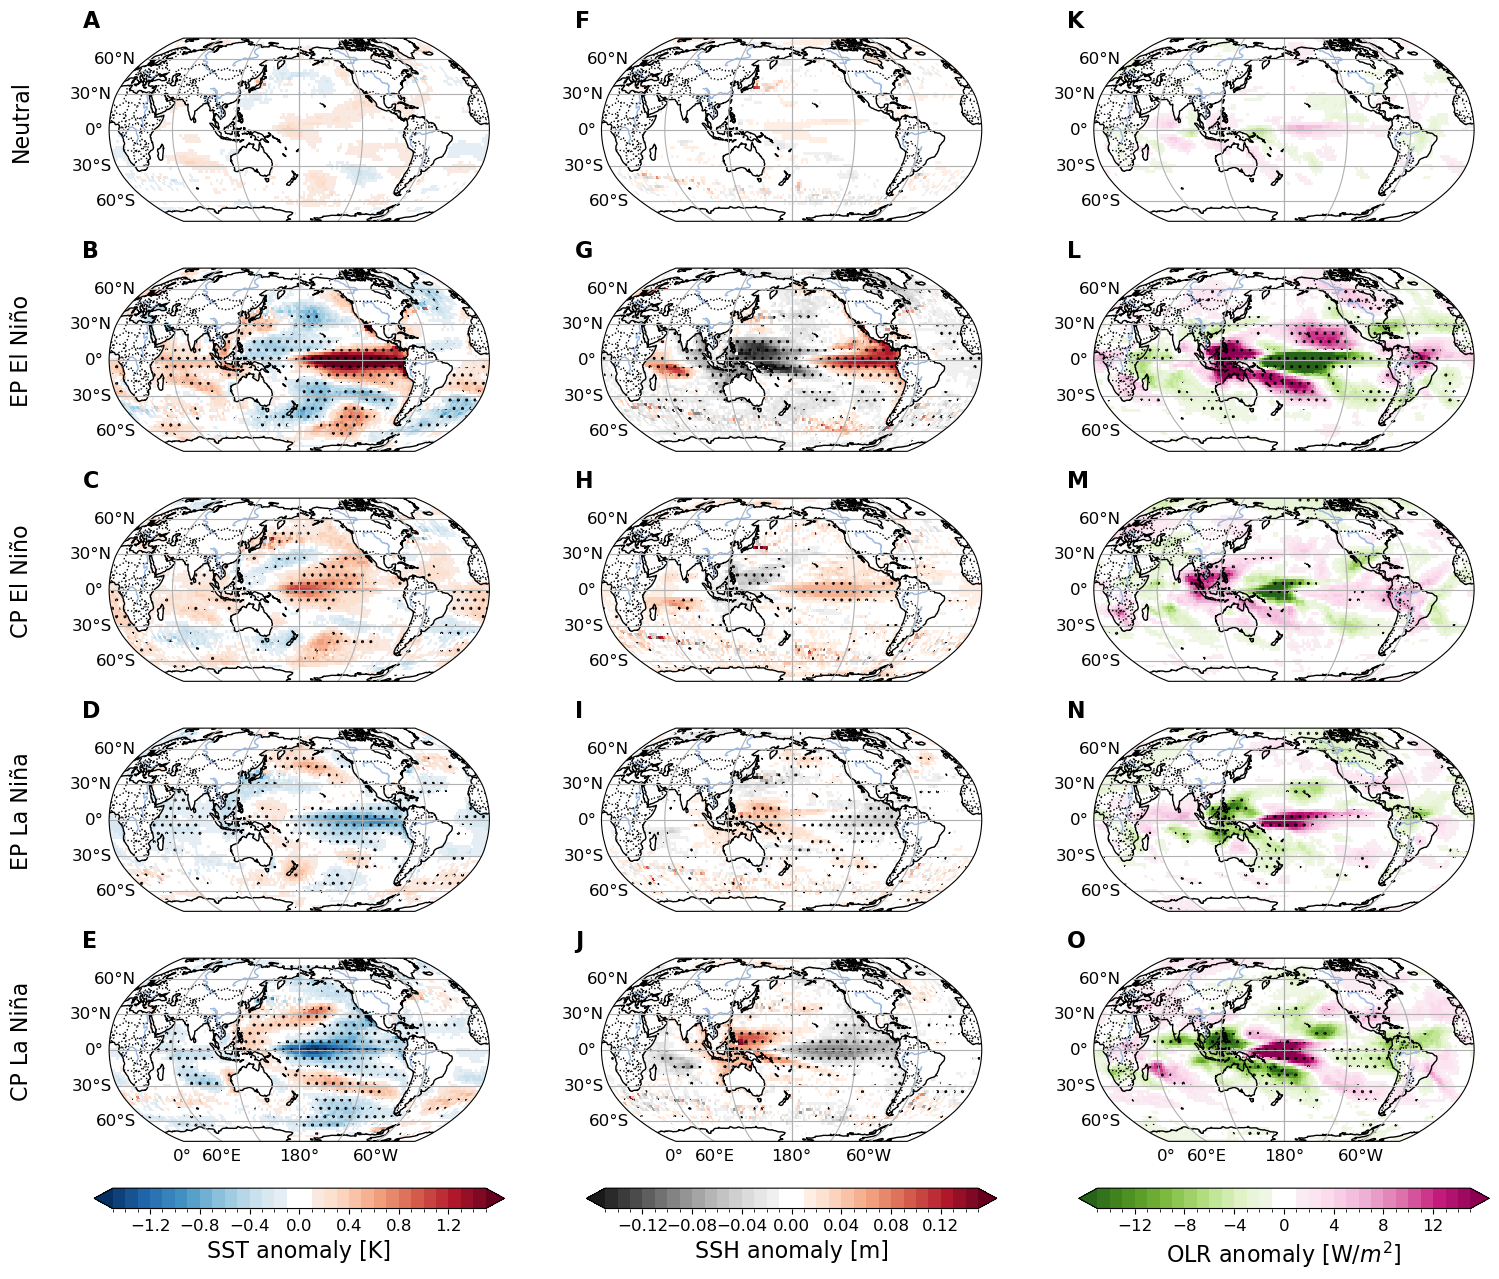

In [8]:
# Plot unweighted composites
n_columns = len(composites_unweight.data_vars)
n_rows = len(composites_unweight['classes']) + 1
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows+1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

labels = ["EP El Niño", "CP El Niño", "EP La Niña", "CP La Niña"]
axs = []
for j in range(n_columns):
    var = list(composites_unweight.data_vars)[j]

    # Neutral composites
    ax = fig.add_subplot(gs[0, j], projection=proj)
    im = gpl.plot_map(composites_null[var], central_longitude=0, ax=ax,
                      bar='discrete', add_bar=False,
                      cmap=plotspec[var]['cmap'],
                      vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                      step=plotspec[var]['step'], centercolor='#FFFFFF')
    if j == 0:
        ax.text(-0.2, 0.55, rf"Neutral", va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes, fontsize=16) 
    axs.append(ax)

    im['gl'].top_labels = False
    im['gl'].right_labels = False
    im['gl'].bottom_labels = False

    # ENSO flavor composites
    for i in range(len(composites_unweight['classes'])):
        comp = composites_unweight[var].isel(classes=i)
        mask = mask_unweight[var].isel(classes=i)
        ax = fig.add_subplot(gs[i+1, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax,
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i+1 == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False
        
        if j == 0:
            ax.text(-0.2, 0.55, rf"{labels[i]}", va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=16) 

        axs.append(ax)

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-0.07, pos_y=1.06, fontsize=16)

plt.savefig("../output/plots/pcgmm_unweighted_composites.png", dpi=300, bbox_inches='tight')


## Plot histograms

Text(0.5, 1.0, 'PoS: 0.00, significance: True')

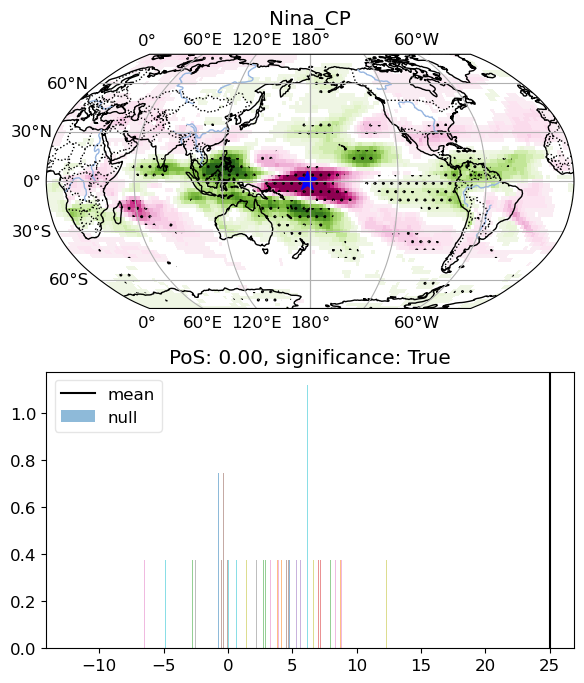

In [9]:
idx = 3
var = 'olra'
lat = 0.0
lon = 178 
mean = composites_unweight[var].isel(classes=idx)
mask = mask_unweight[var].isel(classes=idx)
samples_null = samples_null_unweight[var]

fig = plt.figure(figsize=(6,7))

central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)
ax1 = fig.add_subplot(211, projection=proj)
im = gpl.plot_map(mean,
                  ax=ax1, central_longitude=0, 
                  bar='discrete', add_bar=False,
                  cmap=plotspec[var]['cmap'],
                  vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                  step=plotspec[var]['step'], centercolor='#FFFFFF')
gpl.significance_mask(mask, ax=ax1, hatch='..',
                      central_longitude=0)

ax1.scatter(lon, lat, transform=ctp.crs.PlateCarree(),
           marker='*', color='b', s=200)
ax1.set_title(f"{mean['classes'].data}")
# Hist
ax2 = fig.add_subplot(212)
ax2.axvline(mean.sel(lon=lon, lat=lat, method='nearest'), color='k', label='mean')
ax2.hist(samples_null.sel(lon=lon, lat=lat, method='nearest').data,
        bins='auto', density=True, alpha=0.5, label='null')
ax2.legend()
ax2.set_title(f"PoS: {pvals_prob[var].isel(classes=idx).sel(lon=lon, lat=lat, method='nearest').data:.2f}"+
      f", significance: {mask.sel(lon=lon, lat=lat, method='nearest').data}")
